# Window function and amplitude correction

In [1]:
from radiocalibrationtoolkit import *
from scipy.signal import butter, lfilter
from scipy.signal import blackmanharris, boxcar, hann

[INFO] LFmap: Import successful.


In [2]:
# some global plot settings
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = 16
plt.rcParams["legend.fontsize"] = 12

plt.rcParams["xtick.major.width"] = 2
plt.rcParams["ytick.major.width"] = 2

plt.rcParams["xtick.major.size"] = 5
plt.rcParams["ytick.major.size"] = 5

plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

## Examine effects on a single trace

In [3]:
N = 2048   # samples
fs_Hz = 250e6 # sampling frequency
signal_freq_Hz = 55.5e6 # signal
win = blackmanharris(N) # window function type

In [4]:
tx = np.arange(N) / fs_Hz
def make_simple_time_trace(signal_amplitude=0.7, signal_frequency=55.5e+6, noise_amplitude=1, N=2048, apply_filter=True):
    time_trace = signal_amplitude * np.sin(2*np.pi*signal_frequency*tx) + noise_amplitude * np.random.normal(size=N)
    b, a = butter(5, [30e6, 80e6], fs=250e6, btype='band')
    if apply_filter:
        time_trace = lfilter(b, a, time_trace)
    return np.round(time_trace * N) / N

Text(0, 0.5, 'amplitude [ADC]')

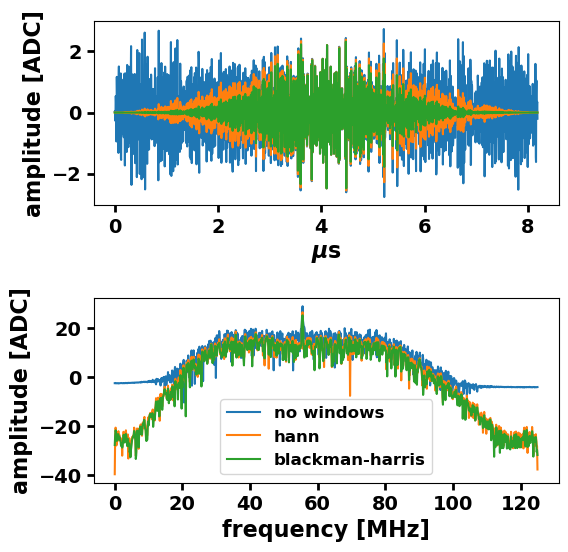

In [5]:
tt = make_simple_time_trace(signal_amplitude=1)
fx = np.fft.rfftfreq(N, 1/fs_Hz)*1e-6

fig, ax = plt.subplots(2,1, figsize=(6,6))
labels = ['no windows', 'hann', 'blackman-harris']
for i, w in enumerate([1, hann(N), blackmanharris(N)]):
    ax[0].plot(tx*1e+6, tt*w)
    ax[1].plot(fx, 10*np.log10(np.abs(np.fft.rfft(tt*w))), label=labels[i])

fig.subplots_adjust(hspace=0.5)
ax[1].legend()

ax[0].set_xlabel("$\mu$s")
ax[1].set_xlabel("frequency [MHz]")
ax[0].set_ylabel("amplitude [ADC]")
ax[1].set_ylabel("amplitude [ADC]")


In [6]:
# generate time trace
time_trace = make_simple_time_trace()

# calculate two sided spectrum
spectrum = np.abs(fft(time_trace))
# calculate one sided spectrum (not corrected for the one side)
rspectrum = np.abs(np.fft.rfft(time_trace))

# calculate one sided spectrum (corrected for the one side)
r2spectrum = correct_energy_of_one_sided_spectrum(rspectrum)

# calculate amplitude window function correction
Aw = N/np.sum(win) /np.sqrt(2)

# calculate two sided spectrum using a window function (not corrected for the one side)
spectrum_w = np.abs(fft(time_trace*win))
# calculate one sided spectrum using a window function (not corrected for the one side)
rspectrum_w = np.abs(np.fft.rfft(time_trace*win))

# calculate one sided spectrum (corrected for the one side)
r2spectrum = correct_energy_of_one_sided_spectrum(rspectrum)
r2spectrum_w = correct_energy_of_one_sided_spectrum(rspectrum_w)

# define X-axis values
fx = np.fft.rfftfreq(N, 1/fs_Hz)/1e+6

In [7]:
# calculate energy from time trace, one and two sided spectrum with and without window
# when the window is used, the amplitudes are corrected
print(
    f"Energy calculated from:\n"
    f"time trace = {get_energy_from_time_trace(time_trace):.2f},\n"
    f"two sided spectrum = {get_energy_from_two_sided_spectrum(spectrum):.2f},\n"
    f"one sided spectrum = {get_energy_from_one_sided_spectrum(rspectrum):.2f},\n"
    f"windowed two sided spectrum = {get_energy_from_two_sided_spectrum(spectrum_w):.2f},\n"
    f"one sided spectrum corrected for being the one sided spectrum = {get_energy_from_one_sided_spectrum_corrected4one_side(r2spectrum):.2f},\n"
    f"windowed two sided spectrum corrected by window function loss = {get_energy_from_two_sided_spectrum(spectrum_w * Aw):.2f},\n"
    f"windowed one sided spectrum corrected by window function loss = {get_energy_from_one_sided_spectrum(rspectrum_w * Aw):.2f},\n"
    f"one sided spectrum corrected for being the one sided spectrum and for window function loss = {get_energy_from_one_sided_spectrum_corrected4one_side(r2spectrum_w*Aw):.2f},\n"
)

Energy calculated from:
time trace = 1256.68,
two sided spectrum = 1256.68,
one sided spectrum = 1256.68,
windowed two sided spectrum = 308.23,
one sided spectrum corrected for being the one sided spectrum = 1256.68,
windowed two sided spectrum corrected by window function loss = 1198.63,
windowed one sided spectrum corrected by window function loss = 1198.63,
one sided spectrum corrected for being the one sided spectrum and for window function loss = 1198.63,



### Trace with a broad band pulse

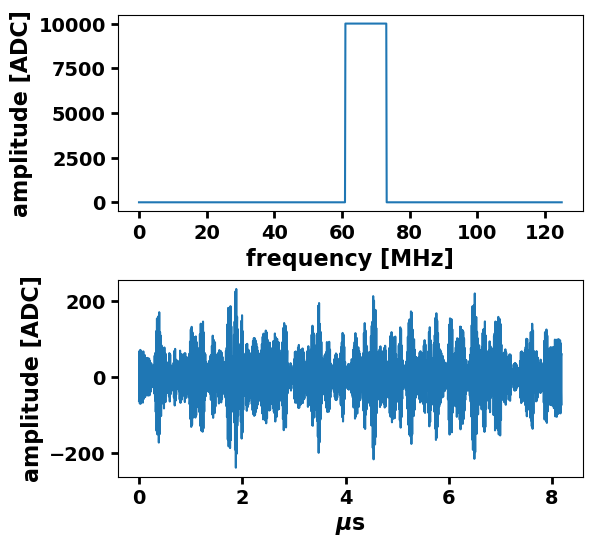

In [8]:
# create a broad band noise trace
bb_spec=np.zeros(1025)
bb_spec[500:600] = 10000


bb_tt = np.real(ifft(one_sided_2_complex_two_sided(bb_spec)))

fig, ax = plt.subplots(2,1, figsize=(6,6))

ax[0].set_xlabel("frequency [MHz]")
ax[0].set_ylabel("amplitude [ADC]")
ax[1].set_ylabel("amplitude [ADC]")
ax[1].set_xlabel("$\mu$s")

ax[0].plot(fx, bb_spec)
ax[1].plot(tx*1e+6, bb_tt)

fig.subplots_adjust(hspace=0.35)

In [9]:
# add broad band pulse to the time trace
time_trace_e = time_trace.copy()
time_trace_e[np.arange(1024, 1024+40)] = bb_tt[:40]

rspectrum_e = np.abs(np.fft.rfft(time_trace_e))
rspectrum_w_e = np.abs(np.fft.rfft(time_trace_e*win))


In [10]:
def show_plots(time_trace, show_window_func=True):
    rspectrum = np.abs(np.fft.rfft(time_trace))
    rspectrum_w = np.abs(np.fft.rfft(time_trace * win))
    Aw = N / np.sum(win) / np.sqrt(2)

    e_tt = get_energy_from_time_trace(time_trace)
    e_spec = get_energy_from_one_sided_spectrum(rspectrum)
    e_spec_w = get_energy_from_one_sided_spectrum(rspectrum_w * Aw)

    fig, ax = plt.subplots(2, 1, figsize=(6, 6))

    mu = 1e6
    ax[0].plot(
        tx * mu, time_trace, label="no window: E={:.1f} a.u.".format(e_tt), alpha=0.7
    )
    ax[0].plot(tx * mu, time_trace * win, label="windowed", alpha=0.7)
    
    if show_window_func:
        ax[0].plot(tx * mu, win * 100, label="window func. x100", alpha=1)

    ax[1].plot(
        fx , rspectrum, label="no window:         E={:.1f} a.u.".format(e_spec), alpha=0.7
    )

    ax[1].plot(
        fx ,
        rspectrum_w * Aw,
        label="windowed & A$_w$: E={:.1f} a.u.".format(e_spec_w),
        alpha=0.7,
    )

    display(
        get_energy_from_time_trace(time_trace),
        get_energy_from_one_sided_spectrum(rspectrum),
        get_energy_from_one_sided_spectrum(rspectrum_w * Aw),
    )

    ax[0].set_xlabel("$\mu$s")
    ax[1].set_xlabel("frequency [MHz]")
    ax[0].set_ylabel("amplitude [ADC]")
    ax[1].set_ylabel("amplitude [ADC]")

    ax[0].legend()
    ax[1].legend()
    
    fig.subplots_adjust(hspace=0.3)

1256.6836211681366

1256.6836211681366

1198.6275145885643

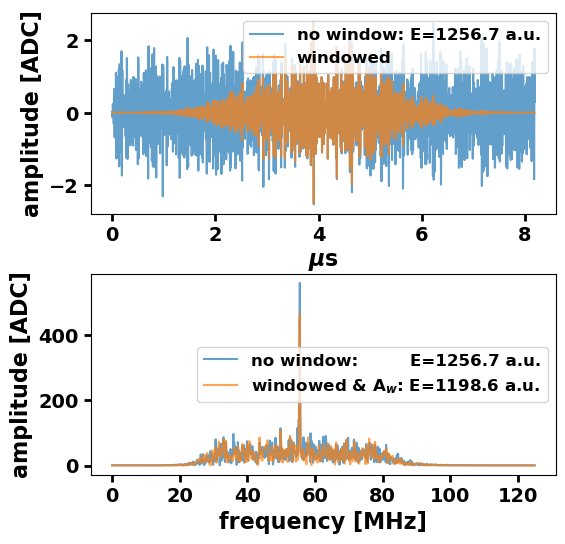

In [11]:
# trace without the broad band pulse
show_plots(time_trace, show_window_func=False)

87316.50391464922

87316.50391464923

334385.1512066299

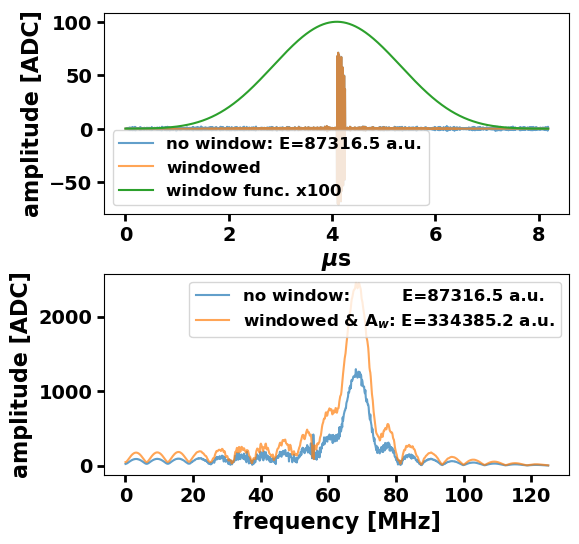

In [12]:
# trace with the broad band pulse
time_trace_e = time_trace.copy()
time_trace_e[np.arange(1024, 1024+40)] = bb_tt[:40]
show_plots(time_trace_e)

87316.50391464922

87316.50391464923

16213.107291350754

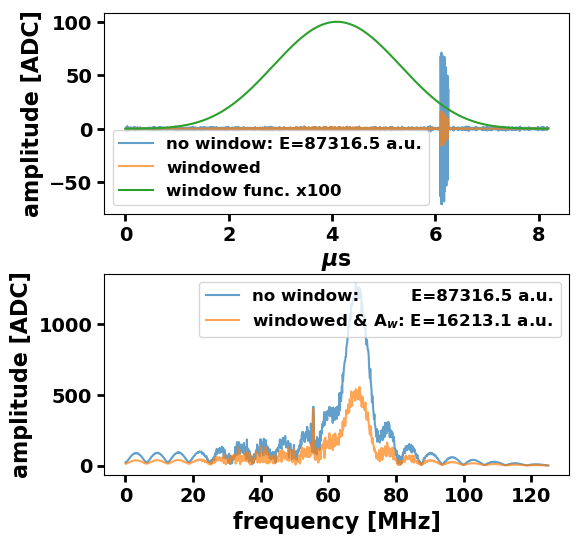

In [13]:
# rolled trace to shift the broad band pulse
show_plots(np.roll(time_trace_e, 500))

The learning here is that a amplitudes of a trace with broad band pulse cannot be safely corrected
after the window function because the window function is symmetric and the broad band pulse appearing 
in random parts of the trace will be each time differently supressed by the window function.

Note that the energy of the trace is after the rolling of the trace still the same when no window is used.

## Distributions of the energy ratios of not windowed spectra and windowed spectra with amplitude correction

In [14]:
def get_averaged_spectra_and_diffs(arr):
    diffs = np.array([])
    n, N = arr.shape
    avr_rspectrum = 0
    avr_rspectrum_w = 0
    win = blackmanharris(N)
    Aw = N / np.sum(win) / np.sqrt(2)
    for i in range(n):
        time_trace = arr[i, :]
        rspectrum = np.abs(np.fft.rfft(time_trace))
        rspectrum_w = np.abs(np.fft.rfft(time_trace * win))
        diffs = np.append(
            diffs,
            get_energy_from_time_trace(time_trace)
            / get_energy_from_one_sided_spectrum(rspectrum_w * Aw),
        )
        avr_rspectrum += rspectrum
        avr_rspectrum_w += rspectrum_w

    avr_rspectrum /= n
    avr_rspectrum_w /= n
    return avr_rspectrum, avr_rspectrum_w, diffs


def show_results(
    avr_rspectrum,
    avr_rspectrum_w,
    diffs,
    histo_edge=2,
    N=2048,
    bins=None,
    xax_min=None,
    xax_max=None,
    xlim= [None, None]
):
    fig, ax = plt.subplots()
    fx = np.fft.rfftfreq(N, 1 / fs_Hz) / 1e6

    if bins == None:
        bins = linspace_with_middle_value(
            np.mean(diffs), histo_edge * np.std(diffs), 20
        )
    ax.hist(diffs, bins=bins)
    # Calculate mean and standard deviation
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs)

    print(mean_diff)
    print(std_diff)

    # Add text box with mean and standard deviation
    text_box = f"$\mu$: {mean_diff:.2f}\n$\sigma$: {std_diff:.2f}"
    ax.text(
        0.95,
        0.95,
        text_box,
        transform=ax.transAxes,
        verticalalignment="top",
        horizontalalignment="right",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.5),
    )

    ax.set_xlim(xax_min, xax_max)
    ax.set_xlabel(
        r"$\frac{\mathrm{energy: \ spectrum \ with \ no\ window}}{\mathrm{energy:spectrum \ with\ window,\ amplitudes\ corrected}}$"
    )
    ax.set_ylabel("entries")

    fig, ax = plt.subplots()

    ax.plot(fx, voltageAmp2dB(avr_rspectrum), alpha=0.7, label="no window")
    ax.plot(fx, voltageAmp2dB(avr_rspectrum_w), alpha=0.7, label="with window")
    ax.plot(
        fx,
        voltageAmp2dB(avr_rspectrum_w * Aw),
        alpha=0.7,
        label="with window " + "\n" + "and corrected",
    )
    
    
    # ax.axes.axvspan(30,80, color='b', alpha=0.1)
    ax.set_xlim(*xlim)
    autoscale_y(ax)     
    
    ax.set_xlabel("frequency [MHz]")
    ax.set_ylabel("dB")
    ax.legend()

### Simple traces

In [15]:
# create a set of 1000 time traces
n = 1000
avr_rspectrum = 0
avr_rspectrum_w = 0
time_traces = make_simple_time_trace()
for i in range(n-1):
    time_traces = np.vstack((time_traces, make_simple_time_trace()))

In [16]:
# calculate energy ratios of unwindowed spectra and windowed with amplitude correction
# and average spectra
avr_rspectrum, avr_rspectrum_w, diffs = get_averaged_spectra_and_diffs(time_traces)
diffs1 = diffs
label4final_histo = ['simple traces']

0.9997098870959144
0.06186278133689926


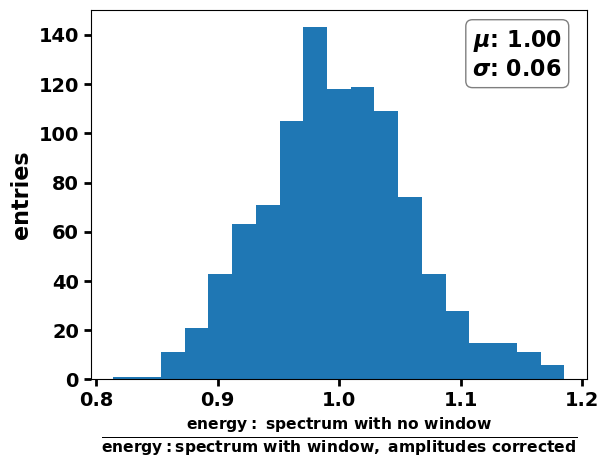

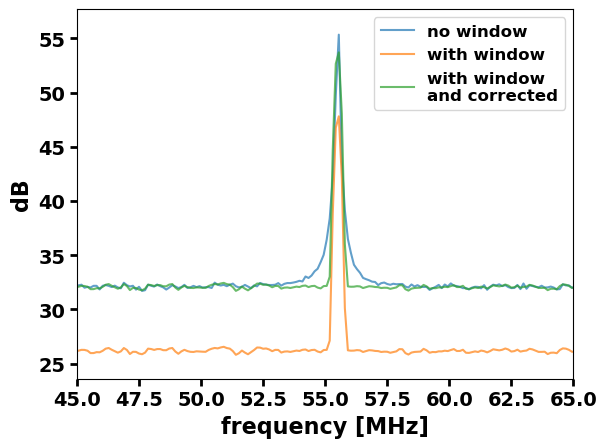

In [17]:
show_results(avr_rspectrum, avr_rspectrum_w, diffs, histo_edge=3, xlim=[45, 65])

In [18]:
# create a set of 1000 time traces with bb pulses
n = 1000
avr_rspectrum = 0
avr_rspectrum_w = 0
time_traces = make_simple_time_trace()
for i in range(n-1):
    time_trace = make_simple_time_trace()
    start_bb_index = np.random.randint(0, 2048-40)
    time_trace[np.arange(start_bb_index, start_bb_index+40)] = bb_tt[:40]
    time_traces = np.vstack((time_traces, time_trace))

In [19]:
avr_rspectrum, avr_rspectrum_w, diffs = get_averaged_spectra_and_diffs(time_traces)

23.238728726820554
27.540605849461983


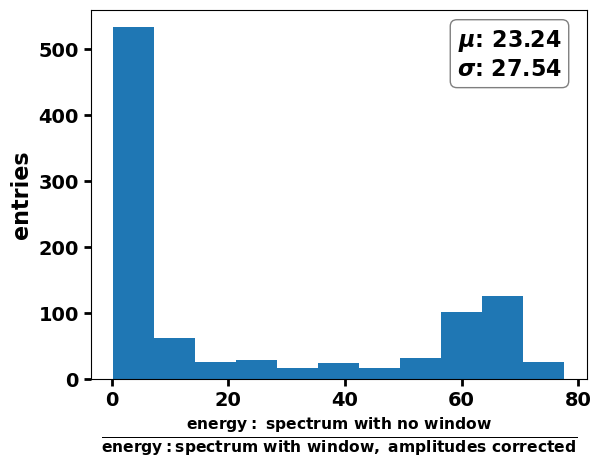

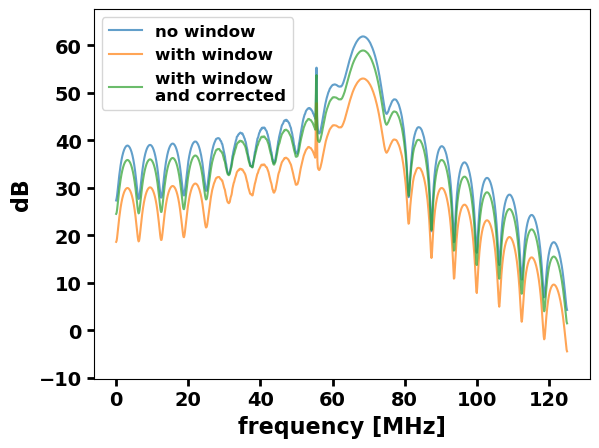

In [20]:
show_results(avr_rspectrum, avr_rspectrum_w, diffs, histo_edge=3, bins='auto')
# ,xax_min=-10, xax_max=80)

### Mock traces

In [21]:
# read HW response
hw_file_path = "./antenna_setup_files/HardwareProfileList_realistic.xml"
hw_dict = read_hw_file(hw_file_path, interp_args={"fill_value": "extrapolate"})

hw_reponse_1 = hw_dict["RResponse"]["LNA"]
hw_reponse_2 = hw_dict["RResponse"]["digitizer"]
hw_reponse_3 = hw_dict["RResponse"]["cable_fromLNA2digitizer"]
hw_reponse_4 = hw_dict["RResponse"]["impedance_matching_EW"]


# merge all hw responses to one function
def hw_response_func(x):
    return dB2PowerAmp(
        hw_reponse_1(x) + hw_reponse_2(x) + hw_reponse_3(x) + hw_reponse_4(x)
    )


# impedance function
impedance_func = hw_dict["IImpedance"][
    "antenna_EW"
]

# read sidereal voltage square spectral density
sidereal_voltage2_density_DF = pd.read_csv(
    "./voltage2_density/voltage2_density_Salla_EW_GSM16.csv",
    index_col=0,
)
sidereal_voltage2_density_DF.columns = sidereal_voltage2_density_DF.columns.astype(
    float
)

<?xml version="1.0" encoding="iso-8859-1"?>
<Element HardwareProfileList at 0x7ff55133c3c0>


In [22]:
mock_trace_generator = Mock_trace_generator(
    sidereal_voltage2_density_DF=sidereal_voltage2_density_DF,
    hw_response_func=hw_response_func,
    impedance_func=impedance_func,
    voltage2ADC=2048,
    time_trace_size=2048,
    sampling_frequency_MHz=250,
)
freq_MHz_bins = mock_trace_generator.get_frequency_bins()

In [23]:
piko = 1e-12
additional_noise = 5e-4*piko
debug_spectra_dict = mock_trace_generator.generate_mock_trace(
    1,
    lst=15,
    temp_celsius=30,
    nbi={"67.2": 1},
    nbi_err=0.2,
    return_debug_dict=True,
    additional_noise=additional_noise,
)[0]

  0%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 226.14it/s]

In [24]:
number_of_traces = 1000
mock_traces_DF = mock_trace_generator.generate_mock_trace(
    number_of_traces,
    temp_celsius=[-10,30],
    additional_noise=additional_noise,
    nbi={"67.25": 1},
    nbi_err=0.3,
)

  0%|                                                                                                                                                                             | 0/1000 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                                    | 3/1000 [00:00<00:37, 26.52it/s]

  1%|▉                                                                                                                                                                    | 6/1000 [00:00<00:46, 21.27it/s]

  1%|█▍                                                                                                                                                                   | 9/1000 [00:00<00:56, 17.61it/s]

  1%|█▊                                                                                                                                                                  | 11/1000 [00:00<00:54, 18.18it/s]

  1%|██▏                                                                                                                                                                 | 13/1000 [00:00<00:53, 18.49it/s]

  2%|██▍                                                                                                                                                                 | 15/1000 [00:00<00:52, 18.90it/s]

  2%|██▉                                                                                                                                                                 | 18/1000 [00:00<00:50, 19.59it/s]

  2%|███▎                                                                                                                                                                | 20/1000 [00:01<00:50, 19.59it/s]

  2%|███▊                                                                                                                                                                | 23/1000 [00:01<00:46, 20.89it/s]

  3%|████▍                                                                                                                                                               | 27/1000 [00:01<00:40, 24.08it/s]

  3%|████▉                                                                                                                                                               | 30/1000 [00:01<00:39, 24.85it/s]

  3%|█████▍                                                                                                                                                              | 33/1000 [00:01<00:38, 25.30it/s]

  4%|█████▉                                                                                                                                                              | 36/1000 [00:01<00:36, 26.32it/s]

  4%|██████▍                                                                                                                                                             | 39/1000 [00:01<00:35, 26.77it/s]

  4%|██████▉                                                                                                                                                             | 42/1000 [00:01<00:35, 27.15it/s]

  4%|███████▍                                                                                                                                                            | 45/1000 [00:01<00:34, 27.67it/s]

  5%|███████▊                                                                                                                                                            | 48/1000 [00:02<00:34, 27.83it/s]

  5%|████████▎                                                                                                                                                           | 51/1000 [00:02<00:34, 27.78it/s]

  5%|████████▊                                                                                                                                                           | 54/1000 [00:02<00:34, 27.79it/s]

  6%|█████████▎                                                                                                                                                          | 57/1000 [00:02<00:34, 27.63it/s]

  6%|██████████                                                                                                                                                          | 61/1000 [00:02<00:32, 28.87it/s]

  6%|██████████▋                                                                                                                                                         | 65/1000 [00:02<00:31, 29.52it/s]

  7%|███████████▏                                                                                                                                                        | 68/1000 [00:02<00:37, 24.89it/s]

  7%|███████████▋                                                                                                                                                        | 71/1000 [00:02<00:35, 26.05it/s]

  7%|████████████▏                                                                                                                                                       | 74/1000 [00:03<00:34, 26.87it/s]

  8%|████████████▋                                                                                                                                                       | 77/1000 [00:03<00:33, 27.68it/s]

  8%|█████████████                                                                                                                                                       | 80/1000 [00:03<00:32, 27.93it/s]

  8%|█████████████▌                                                                                                                                                      | 83/1000 [00:03<00:32, 28.24it/s]

  9%|██████████████▎                                                                                                                                                     | 87/1000 [00:03<00:31, 29.12it/s]

  9%|██████████████▉                                                                                                                                                     | 91/1000 [00:03<00:30, 29.70it/s]

 10%|███████████████▌                                                                                                                                                    | 95/1000 [00:03<00:30, 30.10it/s]

 10%|████████████████▏                                                                                                                                                   | 99/1000 [00:03<00:29, 30.21it/s]

 10%|████████████████▊                                                                                                                                                  | 103/1000 [00:03<00:29, 30.47it/s]

 11%|█████████████████▍                                                                                                                                                 | 107/1000 [00:04<00:29, 30.62it/s]

 11%|██████████████████                                                                                                                                                 | 111/1000 [00:04<00:29, 30.45it/s]

 12%|██████████████████▋                                                                                                                                                | 115/1000 [00:04<00:29, 30.49it/s]

 12%|███████████████████▍                                                                                                                                               | 119/1000 [00:04<00:28, 30.59it/s]

 12%|████████████████████                                                                                                                                               | 123/1000 [00:04<00:28, 30.60it/s]

 13%|████████████████████▋                                                                                                                                              | 127/1000 [00:04<00:28, 30.57it/s]

 13%|█████████████████████▎                                                                                                                                             | 131/1000 [00:04<00:28, 30.03it/s]

 14%|██████████████████████                                                                                                                                             | 135/1000 [00:05<00:28, 29.96it/s]

 14%|██████████████████████▋                                                                                                                                            | 139/1000 [00:05<00:28, 30.17it/s]

 14%|███████████████████████▎                                                                                                                                           | 143/1000 [00:05<00:28, 30.29it/s]

 15%|███████████████████████▉                                                                                                                                           | 147/1000 [00:05<00:27, 30.48it/s]

 15%|████████████████████████▌                                                                                                                                          | 151/1000 [00:05<00:28, 29.91it/s]

 15%|█████████████████████████                                                                                                                                          | 154/1000 [00:05<00:28, 29.93it/s]

 16%|█████████████████████████▌                                                                                                                                         | 157/1000 [00:05<00:28, 29.09it/s]

 16%|██████████████████████████                                                                                                                                         | 160/1000 [00:05<00:29, 28.46it/s]

 16%|██████████████████████████▌                                                                                                                                        | 163/1000 [00:05<00:29, 27.98it/s]

 17%|███████████████████████████                                                                                                                                        | 166/1000 [00:06<00:29, 28.41it/s]

 17%|███████████████████████████▌                                                                                                                                       | 169/1000 [00:06<00:29, 28.23it/s]

 17%|████████████████████████████                                                                                                                                       | 172/1000 [00:06<00:29, 28.05it/s]

 18%|████████████████████████████▌                                                                                                                                      | 175/1000 [00:06<00:29, 27.92it/s]

 18%|█████████████████████████████                                                                                                                                      | 178/1000 [00:06<00:29, 27.62it/s]

 18%|█████████████████████████████▌                                                                                                                                     | 181/1000 [00:06<00:29, 27.68it/s]

 18%|█████████████████████████████▉                                                                                                                                     | 184/1000 [00:06<00:29, 27.64it/s]

 19%|██████████████████████████████▍                                                                                                                                    | 187/1000 [00:06<00:29, 27.94it/s]

 19%|██████████████████████████████▉                                                                                                                                    | 190/1000 [00:06<00:28, 28.42it/s]

 19%|███████████████████████████████▍                                                                                                                                   | 193/1000 [00:07<00:28, 27.92it/s]

 20%|███████████████████████████████▉                                                                                                                                   | 196/1000 [00:07<00:28, 28.02it/s]

 20%|████████████████████████████████▍                                                                                                                                  | 199/1000 [00:07<00:29, 27.50it/s]

 20%|████████████████████████████████▉                                                                                                                                  | 202/1000 [00:07<00:29, 27.06it/s]

 20%|█████████████████████████████████▍                                                                                                                                 | 205/1000 [00:07<00:29, 27.12it/s]

 21%|█████████████████████████████████▉                                                                                                                                 | 208/1000 [00:07<00:29, 27.17it/s]

 21%|██████████████████████████████████▍                                                                                                                                | 211/1000 [00:07<00:29, 27.13it/s]

 21%|██████████████████████████████████▉                                                                                                                                | 214/1000 [00:07<00:28, 27.28it/s]

 22%|███████████████████████████████████▎                                                                                                                               | 217/1000 [00:07<00:27, 28.03it/s]

 22%|███████████████████████████████████▊                                                                                                                               | 220/1000 [00:08<00:27, 27.86it/s]

 22%|████████████████████████████████████▎                                                                                                                              | 223/1000 [00:08<00:27, 28.15it/s]

 23%|████████████████████████████████████▊                                                                                                                              | 226/1000 [00:08<00:27, 28.21it/s]

 23%|█████████████████████████████████████▎                                                                                                                             | 229/1000 [00:08<00:27, 28.37it/s]

 23%|█████████████████████████████████████▊                                                                                                                             | 232/1000 [00:08<00:27, 28.10it/s]

 24%|██████████████████████████████████████▎                                                                                                                            | 235/1000 [00:08<00:27, 28.08it/s]

 24%|██████████████████████████████████████▊                                                                                                                            | 238/1000 [00:08<00:27, 27.52it/s]

 24%|███████████████████████████████████████▎                                                                                                                           | 241/1000 [00:08<00:27, 27.54it/s]

 24%|███████████████████████████████████████▊                                                                                                                           | 244/1000 [00:08<00:28, 26.51it/s]

 25%|████████████████████████████████████████▎                                                                                                                          | 247/1000 [00:09<00:28, 26.88it/s]

 25%|████████████████████████████████████████▊                                                                                                                          | 250/1000 [00:09<00:27, 27.30it/s]

 25%|█████████████████████████████████████████▏                                                                                                                         | 253/1000 [00:09<00:27, 27.31it/s]

 26%|█████████████████████████████████████████▋                                                                                                                         | 256/1000 [00:09<00:26, 27.64it/s]

 26%|██████████████████████████████████████████▏                                                                                                                        | 259/1000 [00:09<00:26, 27.88it/s]

 26%|██████████████████████████████████████████▋                                                                                                                        | 262/1000 [00:09<00:26, 28.06it/s]

 26%|███████████████████████████████████████████▏                                                                                                                       | 265/1000 [00:09<00:26, 28.22it/s]

 27%|███████████████████████████████████████████▋                                                                                                                       | 268/1000 [00:09<00:25, 28.28it/s]

 27%|████████████████████████████████████████████▏                                                                                                                      | 271/1000 [00:09<00:25, 28.28it/s]

 27%|████████████████████████████████████████████▋                                                                                                                      | 274/1000 [00:09<00:25, 27.98it/s]

 28%|█████████████████████████████████████████████▏                                                                                                                     | 277/1000 [00:10<00:25, 28.13it/s]

 28%|█████████████████████████████████████████████▋                                                                                                                     | 280/1000 [00:10<00:25, 28.06it/s]

 28%|██████████████████████████████████████████████▏                                                                                                                    | 283/1000 [00:10<00:25, 28.12it/s]

 29%|██████████████████████████████████████████████▌                                                                                                                    | 286/1000 [00:10<00:25, 28.15it/s]

 29%|███████████████████████████████████████████████                                                                                                                    | 289/1000 [00:10<00:25, 28.13it/s]

 29%|███████████████████████████████████████████████▌                                                                                                                   | 292/1000 [00:10<00:25, 27.26it/s]

 30%|████████████████████████████████████████████████                                                                                                                   | 295/1000 [00:10<00:25, 27.28it/s]

 30%|████████████████████████████████████████████████▌                                                                                                                  | 298/1000 [00:10<00:25, 27.41it/s]

 30%|█████████████████████████████████████████████████                                                                                                                  | 301/1000 [00:10<00:25, 27.67it/s]

 30%|█████████████████████████████████████████████████▌                                                                                                                 | 304/1000 [00:11<00:25, 27.77it/s]

 31%|██████████████████████████████████████████████████                                                                                                                 | 307/1000 [00:11<00:25, 26.77it/s]

 31%|██████████████████████████████████████████████████▌                                                                                                                | 310/1000 [00:11<00:25, 27.29it/s]

 31%|███████████████████████████████████████████████████                                                                                                                | 313/1000 [00:11<00:24, 27.68it/s]

 32%|███████████████████████████████████████████████████▌                                                                                                               | 316/1000 [00:11<00:24, 27.85it/s]

 32%|███████████████████████████████████████████████████▉                                                                                                               | 319/1000 [00:11<00:24, 27.85it/s]

 32%|████████████████████████████████████████████████████▍                                                                                                              | 322/1000 [00:11<00:24, 27.93it/s]

 32%|████████████████████████████████████████████████████▉                                                                                                              | 325/1000 [00:11<00:23, 28.17it/s]

 33%|█████████████████████████████████████████████████████▍                                                                                                             | 328/1000 [00:11<00:23, 28.08it/s]

 33%|█████████████████████████████████████████████████████▉                                                                                                             | 331/1000 [00:12<00:24, 27.86it/s]

 33%|██████████████████████████████████████████████████████▍                                                                                                            | 334/1000 [00:12<00:23, 28.10it/s]

 34%|██████████████████████████████████████████████████████▉                                                                                                            | 337/1000 [00:12<00:23, 27.94it/s]

 34%|███████████████████████████████████████████████████████▍                                                                                                           | 340/1000 [00:12<00:23, 28.03it/s]

 34%|███████████████████████████████████████████████████████▉                                                                                                           | 343/1000 [00:12<00:23, 28.13it/s]

 35%|████████████████████████████████████████████████████████▍                                                                                                          | 346/1000 [00:12<00:23, 27.53it/s]

 35%|████████████████████████████████████████████████████████▉                                                                                                          | 349/1000 [00:12<00:23, 27.55it/s]

 35%|█████████████████████████████████████████████████████████▍                                                                                                         | 352/1000 [00:12<00:23, 27.40it/s]

 36%|█████████████████████████████████████████████████████████▊                                                                                                         | 355/1000 [00:12<00:23, 27.16it/s]

 36%|██████████████████████████████████████████████████████████▎                                                                                                        | 358/1000 [00:13<00:23, 27.16it/s]

 36%|██████████████████████████████████████████████████████████▊                                                                                                        | 361/1000 [00:13<00:23, 27.18it/s]

 36%|███████████████████████████████████████████████████████████▎                                                                                                       | 364/1000 [00:13<00:23, 27.38it/s]

 37%|███████████████████████████████████████████████████████████▊                                                                                                       | 367/1000 [00:13<00:22, 27.58it/s]

 37%|████████████████████████████████████████████████████████████▎                                                                                                      | 370/1000 [00:13<00:22, 27.63it/s]

 37%|████████████████████████████████████████████████████████████▊                                                                                                      | 373/1000 [00:13<00:22, 27.83it/s]

 38%|█████████████████████████████████████████████████████████████▎                                                                                                     | 376/1000 [00:13<00:22, 28.10it/s]

 38%|█████████████████████████████████████████████████████████████▊                                                                                                     | 379/1000 [00:13<00:22, 28.01it/s]

 38%|██████████████████████████████████████████████████████████████▎                                                                                                    | 382/1000 [00:13<00:22, 27.47it/s]

 38%|██████████████████████████████████████████████████████████████▊                                                                                                    | 385/1000 [00:13<00:22, 27.43it/s]

 39%|███████████████████████████████████████████████████████████████▏                                                                                                   | 388/1000 [00:14<00:22, 27.52it/s]

 39%|███████████████████████████████████████████████████████████████▋                                                                                                   | 391/1000 [00:14<00:22, 27.12it/s]

 39%|████████████████████████████████████████████████████████████████▏                                                                                                  | 394/1000 [00:14<00:22, 27.18it/s]

 40%|████████████████████████████████████████████████████████████████▋                                                                                                  | 397/1000 [00:14<00:21, 27.62it/s]

 40%|█████████████████████████████████████████████████████████████████▏                                                                                                 | 400/1000 [00:14<00:21, 27.85it/s]

 40%|█████████████████████████████████████████████████████████████████▋                                                                                                 | 403/1000 [00:14<00:21, 27.89it/s]

 41%|██████████████████████████████████████████████████████████████████▏                                                                                                | 406/1000 [00:14<00:21, 27.79it/s]

 41%|██████████████████████████████████████████████████████████████████▋                                                                                                | 409/1000 [00:14<00:21, 28.13it/s]

 41%|███████████████████████████████████████████████████████████████████▏                                                                                               | 412/1000 [00:14<00:20, 28.30it/s]

 42%|███████████████████████████████████████████████████████████████████▋                                                                                               | 415/1000 [00:15<00:20, 27.99it/s]

 42%|████████████████████████████████████████████████████████████████████▏                                                                                              | 418/1000 [00:15<00:20, 27.77it/s]

 42%|████████████████████████████████████████████████████████████████████▌                                                                                              | 421/1000 [00:15<00:20, 27.77it/s]

 42%|█████████████████████████████████████████████████████████████████████                                                                                              | 424/1000 [00:15<00:20, 27.99it/s]

 43%|█████████████████████████████████████████████████████████████████████▌                                                                                             | 427/1000 [00:15<00:20, 28.05it/s]

 43%|██████████████████████████████████████████████████████████████████████                                                                                             | 430/1000 [00:15<00:20, 27.90it/s]

 43%|██████████████████████████████████████████████████████████████████████▌                                                                                            | 433/1000 [00:15<00:20, 27.83it/s]

 44%|███████████████████████████████████████████████████████████████████████                                                                                            | 436/1000 [00:15<00:20, 27.86it/s]

 44%|███████████████████████████████████████████████████████████████████████▌                                                                                           | 439/1000 [00:15<00:20, 27.68it/s]

 44%|████████████████████████████████████████████████████████████████████████                                                                                           | 442/1000 [00:16<00:20, 27.89it/s]

 44%|████████████████████████████████████████████████████████████████████████▌                                                                                          | 445/1000 [00:16<00:19, 28.09it/s]

 45%|█████████████████████████████████████████████████████████████████████████                                                                                          | 448/1000 [00:16<00:19, 27.96it/s]

 45%|█████████████████████████████████████████████████████████████████████████▌                                                                                         | 451/1000 [00:16<00:19, 28.03it/s]

 45%|██████████████████████████████████████████████████████████████████████████                                                                                         | 454/1000 [00:16<00:19, 27.80it/s]

 46%|██████████████████████████████████████████████████████████████████████████▍                                                                                        | 457/1000 [00:16<00:19, 27.97it/s]

 46%|██████████████████████████████████████████████████████████████████████████▉                                                                                        | 460/1000 [00:16<00:19, 28.04it/s]

 46%|███████████████████████████████████████████████████████████████████████████▍                                                                                       | 463/1000 [00:16<00:19, 27.40it/s]

 47%|███████████████████████████████████████████████████████████████████████████▉                                                                                       | 466/1000 [00:16<00:19, 27.85it/s]

 47%|████████████████████████████████████████████████████████████████████████████▍                                                                                      | 469/1000 [00:17<00:18, 28.12it/s]

 47%|████████████████████████████████████████████████████████████████████████████▉                                                                                      | 472/1000 [00:17<00:18, 27.79it/s]

 48%|█████████████████████████████████████████████████████████████████████████████▍                                                                                     | 475/1000 [00:17<00:19, 27.34it/s]

 48%|█████████████████████████████████████████████████████████████████████████████▉                                                                                     | 478/1000 [00:17<00:21, 23.82it/s]

 48%|██████████████████████████████████████████████████████████████████████████████▍                                                                                    | 481/1000 [00:17<00:21, 24.62it/s]

 48%|███████████████████████████████████████████████████████████████████████████████                                                                                    | 485/1000 [00:17<00:19, 26.82it/s]

 49%|███████████████████████████████████████████████████████████████████████████████▌                                                                                   | 488/1000 [00:17<00:18, 27.59it/s]

 49%|████████████████████████████████████████████████████████████████████████████████                                                                                   | 491/1000 [00:17<00:18, 27.53it/s]

 49%|████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 494/1000 [00:17<00:18, 27.81it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████                                                                                  | 497/1000 [00:18<00:18, 27.77it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 501/1000 [00:18<00:17, 28.90it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                | 504/1000 [00:18<00:17, 29.07it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                | 507/1000 [00:18<00:16, 29.19it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████▏                                                                               | 510/1000 [00:18<00:16, 29.34it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████▌                                                                               | 513/1000 [00:18<00:16, 29.48it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████                                                                               | 516/1000 [00:18<00:16, 29.62it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 519/1000 [00:18<00:16, 29.72it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████                                                                              | 522/1000 [00:18<00:16, 29.70it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 526/1000 [00:19<00:15, 29.88it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 530/1000 [00:19<00:15, 29.82it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 533/1000 [00:19<00:16, 28.33it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 536/1000 [00:19<00:16, 28.15it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 539/1000 [00:19<00:16, 28.29it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 542/1000 [00:19<00:16, 28.38it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 545/1000 [00:19<00:16, 28.19it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 548/1000 [00:19<00:16, 28.20it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 551/1000 [00:19<00:15, 28.25it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 555/1000 [00:20<00:15, 28.59it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 558/1000 [00:20<00:15, 28.85it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 562/1000 [00:20<00:14, 29.38it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 566/1000 [00:20<00:14, 29.70it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 570/1000 [00:20<00:14, 29.87it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 573/1000 [00:20<00:14, 29.10it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 576/1000 [00:20<00:14, 28.58it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/1000 [00:20<00:14, 28.20it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 582/1000 [00:20<00:14, 27.95it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 585/1000 [00:21<00:14, 27.80it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 588/1000 [00:21<00:14, 27.72it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 592/1000 [00:21<00:14, 28.62it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 595/1000 [00:21<00:14, 28.64it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 598/1000 [00:21<00:14, 28.28it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 601/1000 [00:21<00:14, 28.06it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 604/1000 [00:21<00:14, 27.80it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 608/1000 [00:21<00:13, 28.71it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 611/1000 [00:22<00:13, 28.53it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 614/1000 [00:22<00:13, 28.15it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 617/1000 [00:22<00:13, 27.98it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 620/1000 [00:22<00:13, 27.90it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 623/1000 [00:22<00:13, 27.80it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 626/1000 [00:22<00:13, 27.68it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 629/1000 [00:22<00:13, 27.65it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 632/1000 [00:22<00:13, 27.54it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 635/1000 [00:22<00:13, 27.53it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 638/1000 [00:22<00:13, 27.49it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 641/1000 [00:23<00:13, 27.48it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 644/1000 [00:23<00:12, 27.46it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 647/1000 [00:23<00:12, 27.74it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 650/1000 [00:23<00:12, 28.28it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 653/1000 [00:23<00:12, 28.60it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 656/1000 [00:23<00:11, 28.69it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 659/1000 [00:23<00:11, 29.00it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 662/1000 [00:23<00:12, 26.26it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 665/1000 [00:23<00:12, 27.18it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 668/1000 [00:24<00:12, 27.48it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 671/1000 [00:24<00:12, 26.23it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 674/1000 [00:24<00:13, 23.96it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 677/1000 [00:24<00:14, 22.68it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 680/1000 [00:24<00:16, 18.83it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 683/1000 [00:24<00:16, 19.21it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 686/1000 [00:25<00:16, 18.92it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 688/1000 [00:25<00:16, 19.04it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 691/1000 [00:25<00:14, 21.21it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 694/1000 [00:25<00:13, 23.03it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 697/1000 [00:25<00:12, 24.38it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 700/1000 [00:25<00:11, 25.46it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 703/1000 [00:25<00:11, 26.33it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 706/1000 [00:25<00:11, 26.69it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 709/1000 [00:25<00:10, 26.78it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 712/1000 [00:26<00:10, 26.85it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 715/1000 [00:26<00:10, 27.46it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 718/1000 [00:26<00:10, 27.66it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 721/1000 [00:26<00:10, 27.59it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 724/1000 [00:26<00:09, 28.11it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 727/1000 [00:26<00:09, 27.69it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 730/1000 [00:26<00:09, 27.48it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 733/1000 [00:26<00:09, 27.38it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 736/1000 [00:26<00:09, 26.98it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 739/1000 [00:26<00:09, 26.74it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 742/1000 [00:27<00:09, 26.74it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 745/1000 [00:27<00:09, 26.61it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 748/1000 [00:27<00:09, 26.68it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 751/1000 [00:27<00:09, 26.79it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 754/1000 [00:27<00:09, 26.92it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 757/1000 [00:27<00:09, 26.92it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 760/1000 [00:27<00:08, 27.04it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 763/1000 [00:27<00:08, 26.91it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 766/1000 [00:27<00:08, 26.79it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 769/1000 [00:28<00:08, 27.17it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 772/1000 [00:28<00:08, 27.42it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 775/1000 [00:28<00:08, 27.70it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 778/1000 [00:28<00:07, 28.15it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 781/1000 [00:28<00:07, 28.14it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 784/1000 [00:28<00:07, 27.66it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 787/1000 [00:28<00:07, 28.05it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 790/1000 [00:28<00:07, 28.25it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 794/1000 [00:28<00:07, 28.94it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 797/1000 [00:29<00:06, 29.20it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 800/1000 [00:29<00:06, 29.18it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 803/1000 [00:29<00:06, 29.32it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 806/1000 [00:29<00:06, 29.47it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 809/1000 [00:29<00:06, 29.46it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 812/1000 [00:29<00:06, 29.37it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 815/1000 [00:29<00:06, 29.17it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 818/1000 [00:29<00:07, 25.25it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 821/1000 [00:29<00:06, 26.10it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 824/1000 [00:30<00:06, 27.00it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 827/1000 [00:30<00:06, 27.41it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 830/1000 [00:30<00:06, 26.94it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 833/1000 [00:30<00:06, 26.79it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 836/1000 [00:30<00:06, 24.64it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 839/1000 [00:30<00:06, 23.67it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 842/1000 [00:30<00:06, 24.80it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 845/1000 [00:30<00:06, 25.45it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 848/1000 [00:30<00:05, 26.27it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 851/1000 [00:31<00:05, 26.79it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 854/1000 [00:31<00:05, 27.18it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 857/1000 [00:31<00:05, 27.66it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 860/1000 [00:31<00:04, 28.06it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 863/1000 [00:31<00:04, 28.31it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 866/1000 [00:31<00:04, 28.40it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 869/1000 [00:31<00:04, 28.14it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 872/1000 [00:31<00:04, 27.10it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 875/1000 [00:31<00:04, 26.28it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 878/1000 [00:32<00:04, 25.51it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 881/1000 [00:32<00:04, 25.82it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 884/1000 [00:32<00:04, 26.61it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 887/1000 [00:32<00:04, 27.42it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 890/1000 [00:32<00:03, 27.92it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 893/1000 [00:32<00:03, 28.37it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 896/1000 [00:32<00:03, 28.50it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 899/1000 [00:32<00:03, 28.32it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 902/1000 [00:32<00:03, 28.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 905/1000 [00:33<00:03, 28.33it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 908/1000 [00:33<00:03, 28.36it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 911/1000 [00:33<00:03, 28.43it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 914/1000 [00:33<00:03, 28.33it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 917/1000 [00:33<00:03, 26.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 920/1000 [00:33<00:02, 26.94it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 923/1000 [00:33<00:02, 26.86it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 926/1000 [00:33<00:03, 23.45it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 929/1000 [00:33<00:02, 23.92it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 932/1000 [00:34<00:02, 24.26it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 935/1000 [00:34<00:02, 24.64it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 938/1000 [00:34<00:02, 25.10it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 941/1000 [00:34<00:02, 26.24it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 944/1000 [00:34<00:02, 26.70it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 947/1000 [00:34<00:02, 26.44it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 950/1000 [00:34<00:01, 26.34it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 953/1000 [00:34<00:01, 26.51it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 956/1000 [00:35<00:01, 26.78it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 959/1000 [00:35<00:01, 26.38it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 962/1000 [00:35<00:01, 26.46it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 965/1000 [00:35<00:01, 26.63it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 968/1000 [00:35<00:01, 26.89it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 971/1000 [00:35<00:01, 27.52it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 974/1000 [00:35<00:00, 27.85it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 977/1000 [00:35<00:00, 27.75it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 980/1000 [00:35<00:00, 27.17it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 983/1000 [00:36<00:00, 27.29it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 986/1000 [00:36<00:00, 27.08it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 989/1000 [00:36<00:00, 26.78it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 992/1000 [00:36<00:00, 26.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 995/1000 [00:36<00:00, 26.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 998/1000 [00:36<00:00, 26.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.28it/s]

In [25]:
avr_rspectrum, avr_rspectrum_w, diffs = get_averaged_spectra_and_diffs(mock_traces_DF.iloc[:,2:].values)
diffs2 = diffs
label4final_histo.append('mock traces')

0.9998152739751677
0.04984770270152377


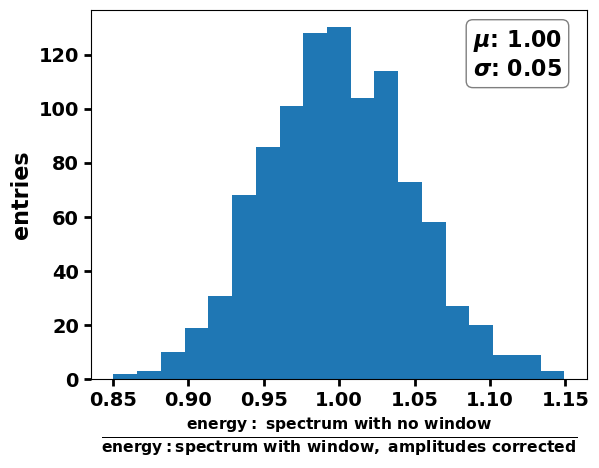

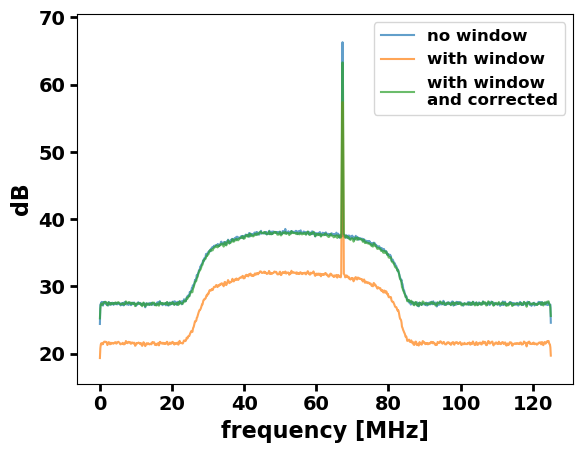

In [26]:
show_results(avr_rspectrum, avr_rspectrum_w, diffs, histo_edge=3)

In [27]:
mock_traces_with_BB_DF = mock_traces_DF.copy(deep=True)
for i in range(mock_traces_with_BB_DF.index.size):
    start_bb_index = np.random.randint(0, 2048-40)
    time_trace = mock_traces_with_BB_DF.iloc[i,2:].values
    time_trace[np.arange(start_bb_index, start_bb_index+40)] = bb_tt[:40]
    mock_traces_with_BB_DF.iloc[i,2:] = time_trace

In [28]:
avr_rspectrum, avr_rspectrum_w, diffs = get_averaged_spectra_and_diffs(mock_traces_with_BB_DF.iloc[:,2:].values)
diffs3 = diffs
label4final_histo.append('mock traces with BB pulse')

6.02686161355626
6.067713616316185


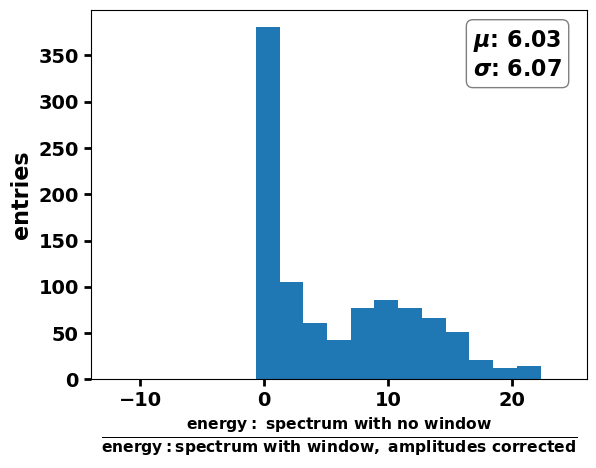

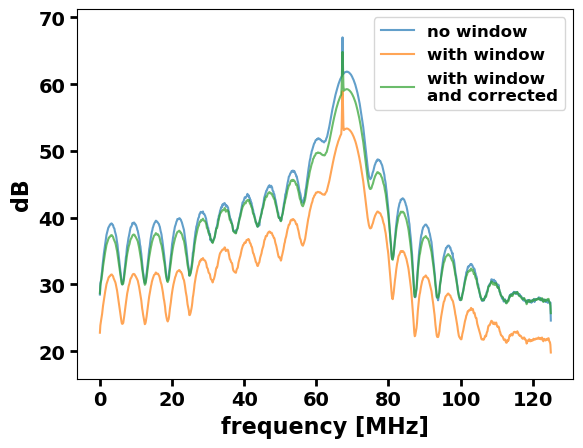

In [29]:
show_results(avr_rspectrum, avr_rspectrum_w, diffs, histo_edge=3)

### Summary

simple traces
Mean and STD:-0.0003, 0.0619
Truncated Mean and STD: -0.0003, 0.0619
******
mock traces
Mean and STD:-0.0002, 0.0498
Truncated Mean and STD: -0.0002, 0.0498
******
mock traces with BB pulse
Mean and STD:5.0269, 6.0677
Truncated Mean and STD: 5.0269, 6.0677
******


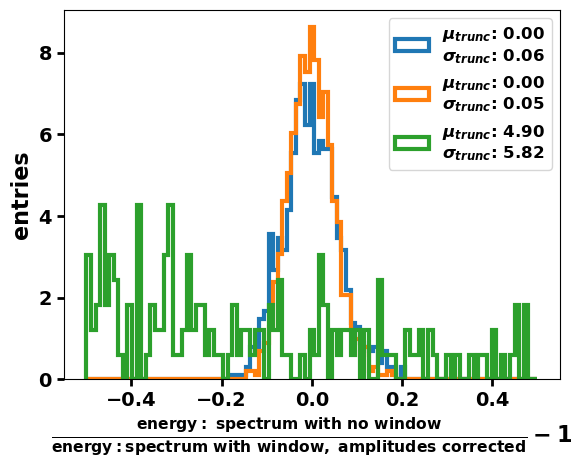

In [30]:
fig, ax = plt.subplots()
fx = np.fft.rfftfreq(N, 1 / fs_Hz) / 1e6

diffs_list = np.asarray([diffs1, diffs2, diffs3], dtype="object") - 1
# diffs_list = [diffs1, diffs2]

bins = np.histogram_bin_edges(np.concatenate(diffs_list), bins=20)


# if bins == None:
bins = linspace_with_middle_value(
    np.mean(np.concatenate(diffs_list)), 2 * np.std(np.concatenate(diffs_list)), 20
)

bins = np.linspace(0.5, 1.5, 100) - 1

for i, diffs in enumerate(diffs_list):
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs)
    mean_diff_trun, std_diff_trun = calculate_truncated_stats(diffs, 1, 99)
    label = (
        text_box
    ) = f"$\mu_{{trunc}}$: {round(mean_diff_trun,2)+0:.2f}\n$\sigma_{{trunc}}$: {round(std_diff_trun,2)+0:.2f}"
    ax.hist(diffs, bins=bins, alpha=1, density=True, histtype="step", lw=3, label=label)
    # Calculate mean and standard deviation
    print(label4final_histo[i])
    print('Mean and STD:{:.4f}, {:.4f}'.format(mean_diff, std_diff))
    print('Truncated Mean and STD: {:.4f}, {:.4f}'.format(mean_diff, std_diff))
    print("******")

# ax.set_xlim(xax_min, xax_max)
ax.set_xlabel(
    r"$\frac{\mathrm{energy: \ spectrum \ with \ no\ window}}{\mathrm{energy:spectrum \ with\ window,\ amplitudes\ corrected}} -1$"
)
ax.set_ylabel("entries")
ax.legend()

In [31]:
print('The colors corespond to')
print(label4final_histo)
print(', respectively.')

The colors corespond to
['simple traces', 'mock traces', 'mock traces with BB pulse']
, respectively.


CONCLUSION: The broad band pulse in the trace spoils the energy recovery.